# Test EOF reconstructions

## Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xarray as xr
import pathlib
import os
import src.utils

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])

## Load data

In [2]:
## MPI data
mpi_load_fp = pathlib.Path(DATA_FP, "mpi_Th", "Th.nc")
Th_mpi = xr.open_dataset(mpi_load_fp)

## EOFs (only do sst)
eofs_fp = pathlib.Path(DATA_FP, "mpi", "eofs300")
eofs_sst = src.utils.load_eofs(eofs_fp / "ts.nc")

# ## for convenience, put PC data into single dataset
# scores = eofs_sst.scores()

eofs_ssh = src.utils.load_eofs(eofs_fp / "ssh.nc")

## for convenience, put components and scores into datasets
components = xr.merge(
    [eofs_sst.components().rename("sst"), eofs_ssh.components().rename("ssh")]
)
scores = xr.merge([eofs_sst.scores().rename("sst"), eofs_ssh.scores().rename("ssh")])

## Compute anomalies

In [3]:
emean, anom = src.utils.separate_forced(scores, n=0)

## Tests

### Identity reconstruction

In [4]:
## get random subset for testing
sample = scores.isel(member=slice(2, 4), time=slice(24, 60))

## identity function
identity = lambda x: x

## reconstruct 2 different ways
r0 = eofs_sst.inverse_transform(sample["sst"])
r1 = src.utils.reconstruct_fn(components["sst"], sample["sst"], fn=identity)

## check allclose
print(f"All close? {np.max(np.abs(r0-r1)).values < 1e-10}")

All close? True


### Niño 3.4 reconstruction

In [5]:
## next, nino 34
n34_r0 = src.utils.get_nino34(r0)
n34_r1 = src.utils.reconstruct_fn(
    eofs_sst.components(), sample["sst"], fn=src.utils.get_nino34
)
print(f"All close? {np.allclose(n34_r0, n34_r1)}\n")

## get reconstruction error on full dataset
n34_recon = src.utils.reconstruct_fn(
    components["sst"], anom["sst"], fn=src.utils.get_nino34
)
h_recon = src.utils.reconstruct_fn(
    components["ssh"], anom["ssh"], fn=src.utils.get_RO_h
)

## compute correlation with non-truncated data
corr_n34 = xr.corr(n34_recon, Th_mpi["T_34"].sel(time=n34_recon.time))
corr_h = xr.corr(h_recon, Th_mpi["h"].sel(time=n34_recon.time))

print(f"Corr w/ non-truncated Niño 3.4 index: {corr_n34:.5f}")
print(f"Corr w/ non-truncated h index:        {corr_h:.5f}")

All close? True

Corr w/ non-truncated Niño 3.4 index: 0.99999
Corr w/ non-truncated h index:        0.99999


Plot a sample

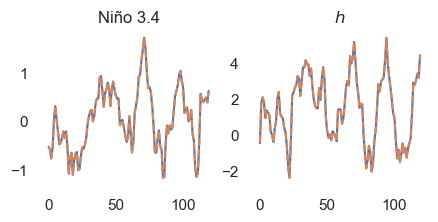

In [6]:
## specify time index for plotting
sample_idx = dict(member=20, time=slice(-120, None))

## set up plot
fig, axs = plt.subplots(1, 2, figsize=(5, 2))

## plot Niño 3.4
axs[0].set_title("Niño 3.4")
axs[0].plot(Th_mpi["T_34"].isel(sample_idx))
axs[0].plot(n34_recon.isel(sample_idx), ls="--")

## plot h
axs[1].set_title(r"$h$")
axs[1].plot(Th_mpi["h"].isel(sample_idx))
axs[1].plot(h_recon.isel(sample_idx), ls="--")

plt.show()

### spatial variance

In [7]:
## compute rolling mean (so ensemble-dim doesn't have zero mean...)
emean, anom = src.utils.separate_forced(scores, n=3)

Gridcell-level

In [8]:
## time index
t_idx = dict(time=slice(-120, None))

## point to check variance at
posn_coords = dict(latitude=-20.5, longitude=200.5)

## compute using custom function
var0_all = src.utils.reconstruct_var(
    scores=anom.isel(t_idx), components=components
).compute()
var0 = var0_all.sel(posn_coords)

## check at single point (reconstruct, then compute variance)
sel_fn = lambda x: x.sel(posn_coords)
recon = src.utils.reconstruct_fn(components, anom.isel(t_idx), fn=sel_fn)
recon_prime = recon - recon.mean(["member", "time"])
var1 = (recon_prime**2).mean(["time", "member"])

## use built-in
var2 = recon.var(["time", "member"])

print(f"All close? {np.allclose(var0.to_dataarray(), var1.to_dataarray())}")
print(f"All close? {np.allclose(var1.to_dataarray(), var2.to_dataarray())}")

All close? True
All close? True


Function of the state (latitude-mean)

In [9]:
## func to get meridional mean
eq_mean = lambda x: x.mean("latitude")

## specify longitude
posn_coords = dict(longitude=200.5)

## compute using custom function
var0_all = src.utils.reconstruct_var(
    scores=anom.isel(t_idx), components=components, fn=eq_mean
).compute()
var0 = var0_all.sel(posn_coords)

## check at single point (reconstruct, then compute variance)
sel_fn = lambda x: eq_mean(x.sel(posn_coords))
recon = src.utils.reconstruct_fn(components, anom.isel(t_idx), fn=sel_fn)
var1 = recon.var(["time", "member"])

print(f"All close? {np.allclose(var0.to_dataarray(), var1.to_dataarray())}")

All close? True


#### synthetic example

In [10]:
m = 100
n = 24

## generate random data
rng = np.random.default_rng()
X = rng.normal(size=(m, n))

## get true variance
varX = np.diag(src.utils.get_cov(X))

## do SVD on data
U, s, Vt = np.linalg.svd(X, full_matrices=False)
S = np.diag(s)

## compute covariance and reconstruct variance
scores_cov = src.utils.get_cov(Vt)
varXhat = np.diag(U @ S @ scores_cov @ S @ U.T)

print(f"All close? {np.allclose(varX, varXhat)}")

All close? True
